In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from sklearn.metrics import accuracy_score , confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import theano.tensor as tt

In [2]:
data = pd.read_csv("balanced_sample.csv")

In [ ]:
print(data.info())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('BuPu')

# Bar chart 
data['AQI_GenPop_Index'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Distribution of my categorical variable')
plt.xlabel('Categories')
plt.ylabel('Frequency')

# Display plot
plt.show()

In [6]:
feature_columns = ['BEN','EBE', 'CO', 'NMHC', 'NO_2', 'O_3', 'PM10', 'PM25', 'SO_2','TCH','TOL'] #11 features - Best

#feature_columns = ["NO_2", "O_3", "PM10", "PM25", "SO_2"] #testing with less //not so good

#feature_columns = ['BEN','EBE', 'CO', 'NMHC', 'NO_2','NOx', 'O_3', 'PM10', 'PM25', 'SO_2','TCH', 'TOL','MXY','OXY','PXY'] #15features to test with more features -NOT BAD

X = data[feature_columns].values

In [7]:
# Target variable y
target_column = "AQI_GenPop_Index" 
y = data[target_column].values

In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = X_train.shape[1]
n_classes=2

In [9]:
# GEN_POP - Binary Bayesian logistic regression model 
with pm.Model() as AQI_model:
    # Priors for coefficients and bias, with better starting values
    coeffs = pm.Normal("coeffs", mu=0, sigma=1, shape=n_features, testval=np.zeros((n_features)))
    bias = pm.Normal("bias", mu=0, sigma=1)
    
    # Likelihood function
    # Define the logistic function with added epsilon
def logistic(x, epsilon=1e-6):
    return 1 / (1 + tt.exp(-x)) + epsilon
       
    p = logistic(pm.math.sigmoid(pm.math.dot(X_train, coeffs) + bias))
    
    # Define the Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [bias, coeffs]


Sampling 3 chains for 1_000 tune and 8_597 draw iterations (3_000 + 25_791 draws total) took 136 seconds.


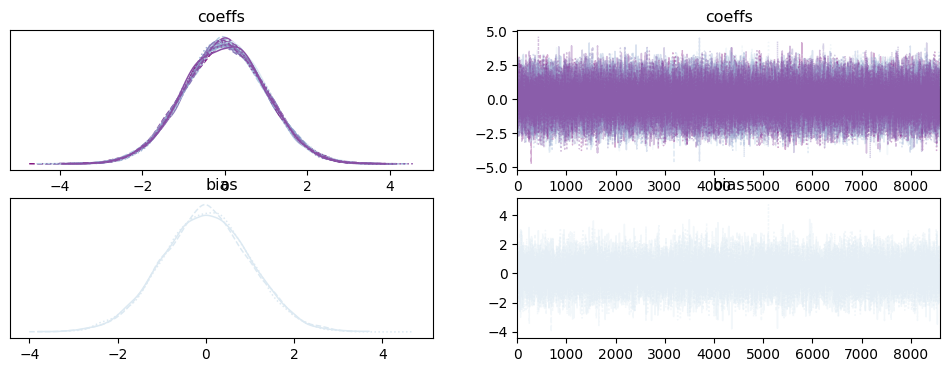

In [26]:
# MCMC
with AQI_model:
    step=pm.NUTS(target_accept=0.8)
    trace = pm.sample(10000, tune=1000, chains=8, cores=8, step=step, progressbar=True)
    sns.set_palette("BuPu")
    pm.plot_trace(trace)

In [ ]:
with AQI_model:
    print(pm.summary(trace))

In [27]:
# BINARY Predicting on test data

def predict_proba(X, trace):
    linear = np.dot(X, trace["coeffs"].mean(axis=0)) + trace["bias"].mean()
    proba = 1 / (1 + np.exp(-linear))
    return np.column_stack((1 - proba, proba)) #this code is the original code

y_test_pred_proba = predict_proba(X_test, trace)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

In [28]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:")

# Evaluation of model performance
accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy:", accuracy)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro') #try also 'micro' or 'weighted'
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)

Confusion matrix:
Test accuracy: 0.65282174188297
Precision: 0.6556438201557935
Recall: 0.6566214877504195
F1 score: 0.6526625001005322


In [24]:
import itertools
def plot_confusion_matrix(cm, classes = ['Safe', 'Hazardous'],
                          title='AQI Safety Confusion matrix',
                          cmap=plt.cm.Purples):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
plot_confusion_matrix(cm)